In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os, sys
import pandas as pd
import sklearn
import sklearn.svm, sklearn.discriminant_analysis, sklearn.linear_model
import time

root = '/usr/local/serenceslab/maggie/shapeDim/'

sys.path.append(os.path.join(root, 'Analysis'))
from code_utils import file_utils, data_utils
from code_utils import decoding_utils
from code_utils import stats_utils, plot_utils


In [2]:
ss=1; make_time_resolved=False
_, _, main_labels, roi_names = data_utils.load_main_task_data(ss, make_time_resolved)

In [3]:
xlabs = np.array(main_labels['ptx'])[main_labels['is_main_grid']==True]
ylabs = np.array(main_labels['pty'])[main_labels['is_main_grid']==True]
unx, uny = np.unique(xlabs), np.unique(ylabs)
pt_labs = np.array([xlabs, ylabs]).T
grid_pts, grid_labs, counts = np.unique(pt_labs, axis=0, return_inverse=True, return_counts=True)
grid_pt_strs = np.array(['(%.1f, %.1f)'%(grid_pts[ii,0], grid_pts[ii,1]) for ii in range(len(grid_pts))])
grid_pt_strs

array(['(0.1, 0.1)', '(0.1, 1.7)', '(0.1, 3.3)', '(0.1, 4.9)',
       '(1.7, 0.1)', '(1.7, 1.7)', '(1.7, 3.3)', '(1.7, 4.9)',
       '(3.3, 0.1)', '(3.3, 1.7)', '(3.3, 3.3)', '(3.3, 4.9)',
       '(4.9, 0.1)', '(4.9, 1.7)', '(4.9, 3.3)', '(4.9, 4.9)'],
      dtype='<U10')

In [4]:
task_names = ['Linear (1)','Linear (2)','Checker', 'Repeat'];
n_tasks = len(task_names)
task_colors = np.flipud(cm.GnBu(np.linspace(0,1,5))[1:,:])

n_subjects = 7
subjects = np.arange(1,8)
subcolors = cm.Dark2(np.linspace(0,1,n_subjects))

In [5]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')

save_filename = os.path.join(save_folder, 'decode_multiclass_crosstask_bigIPS.npy')
dec1 = np.load(save_filename, allow_pickle=True).item()

save_filename = os.path.join(save_folder, 'decode_multiclass_crosstask_IPSall.npy')
dec_ips = np.load(save_filename, allow_pickle=True).item()


# combining the decoding arrays 
roi_names = ['V1', 'V2', 'V3', 'V3AB', 'hV4', 'IPS0', 'IPS1', 'IPS2', 'IPS3', 'LO1', 'LO2']
n_rois = 11

keys_merge = ['acc_bytask', 'dprime_bytask', \
              'acc_each_point_bytask', 'dprime_each_point_bytask', 'num_preds_bytask', \
              'acc_each_cval', 'best_cval']

rois_use1 = [0,1,2,3,4,9,10]

dec_new = dict([])

for kk in keys_merge:
    
    val1 = dec1[kk][:,rois_use1]
    val2 = dec_ips[kk]
    
    val = np.concatenate([val1, val2], axis=1)
    print(val.shape)
    dec_new[kk] = val

roi_names_new = [roi_names[rr] for rr in rois_use1] + ['IPSall']

dec = dec_new
roi_names = roi_names_new
n_rois = len(roi_names)
print(roi_names_new)

(7, 8, 4, 4)
(7, 8, 4, 4)
(7, 8, 16, 4, 4)
(7, 8, 16, 4, 4)
(7, 8, 16, 16, 4, 4)
(7, 8, 4, 12, 20)
(7, 8, 4, 12)
['V1', 'V2', 'V3', 'V3AB', 'hV4', 'LO1', 'LO2', 'IPSall']


In [6]:
roi_names_new

['V1', 'V2', 'V3', 'V3AB', 'hV4', 'LO1', 'LO2', 'IPSall']

In [7]:
for kk in dec.keys():
    try:
        print(kk, dec[kk].shape)
    except:
        print(kk, len(dec[kk]))

acc_bytask (7, 8, 4, 4)
dprime_bytask (7, 8, 4, 4)
acc_each_point_bytask (7, 8, 16, 4, 4)
dprime_each_point_bytask (7, 8, 16, 4, 4)
num_preds_bytask (7, 8, 16, 16, 4, 4)
acc_each_cval (7, 8, 4, 12, 20)
best_cval (7, 8, 4, 12)


In [8]:
# trained/tested same task
within = np.concatenate([dec['acc_bytask'][:,:,ti:ti+1,ti] for ti in range(n_tasks)], axis=2)
within.shape

(7, 8, 4)

In [9]:
# trained/tested diff tasks (average)
across_eachtst = np.concatenate([np.mean(dec['acc_bytask'][:,:,np.arange(n_tasks)!=ti, ti], axis=2, keepdims=True) \
                         for ti in range(n_tasks)], axis=2)
across_eachtrn = np.concatenate([np.mean(dec['acc_bytask'][:,:,ti,np.arange(n_tasks)!=ti], axis=2, keepdims=True) \
                         for ti in range(n_tasks)], axis=2)

across_eachtst.shape, across_eachtrn.shape

((7, 8, 4), (7, 8, 4))

#### Cross-condition generalizability

0.06510416666666666 0.3005952380952381


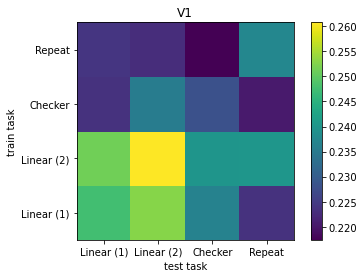

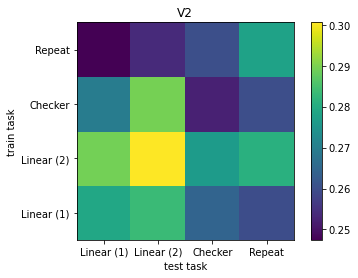

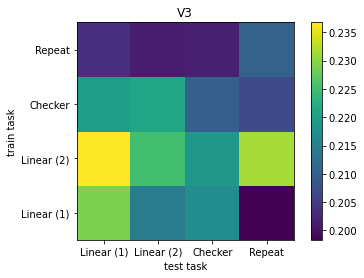

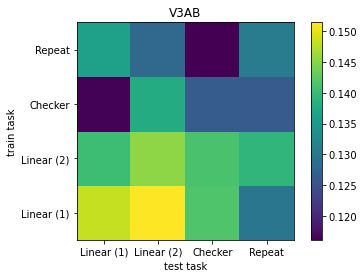

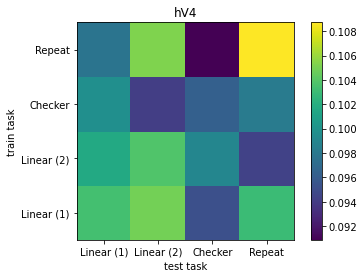

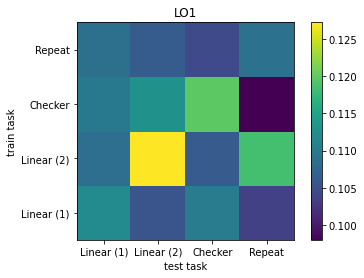

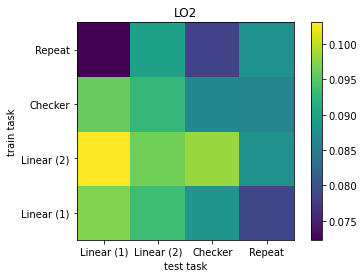

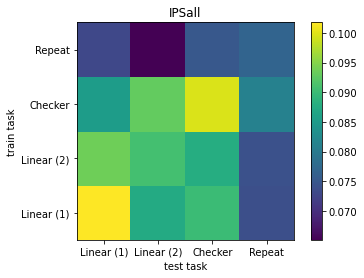

In [10]:
running_min = 1; running_max=0;
# vmin = 0.05; vmax=0.30
# plt.figure(figsize=(12,16))
for ri in range(n_rois):
    
    plt.figure()
    
    mat = np.mean(dec['acc_bytask'][:,ri,:,:], axis=0)
    running_min = np.minimum(np.min(mat), running_min)
    running_max = np.maximum(np.max(mat), running_max)
    
    # plt.subplot(4,3,ri+1)

    plt.pcolormesh(mat)
    plt.axis('square')
    plt.xticks(np.arange(0,4,1)+0.5, labels=task_names);
    plt.yticks(np.arange(0,4,1)+0.5, labels=task_names);
    plt.xlabel('test task')
    plt.ylabel('train task')

    plt.colorbar()
    plt.title(roi_names[ri])
    
print(running_min, running_max)

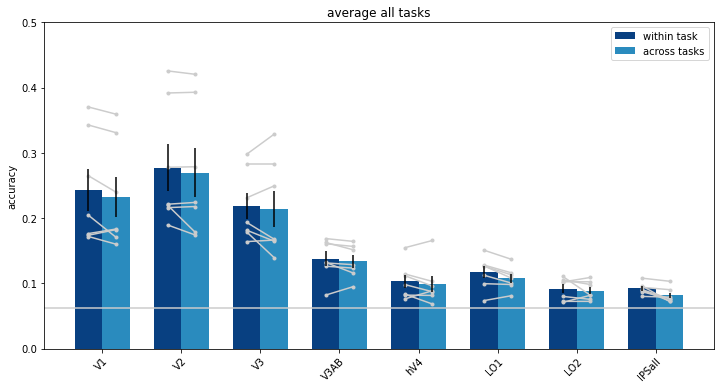

In [13]:
vals = np.concatenate([np.mean(within, axis=2, keepdims=True), \
                       np.mean(across_eachtst, axis=2, keepdims=True)], axis=2)

meanvals = np.mean(vals, axis=0)
semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

plot_utils.plot_multi_bars(mean_data = meanvals, \
                           err_data = semvals, \
                           point_data = vals, \
                           add_ss_lines=True,\
                           colors = task_colors, \
                           space = 0.15, \
                           title = 'average all tasks', \
                           ylim = [0, 0.5], \
                           horizontal_line_pos = 1/16,
                           xticklabels = roi_names, \
                           ylabel = 'accuracy', \
                           legend_overlaid=True, \
                           legend_separate=False, \
                           legend_labels = ['within task','across tasks']);

#### Accuracy versus c (regularization)

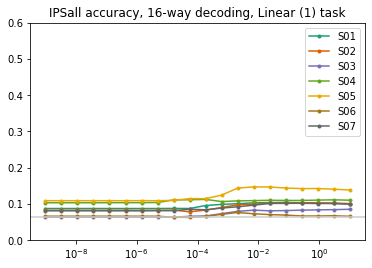

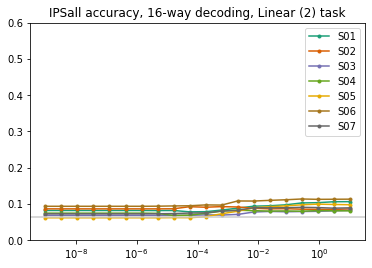

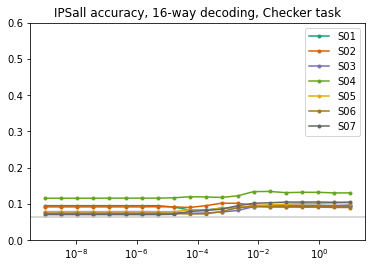

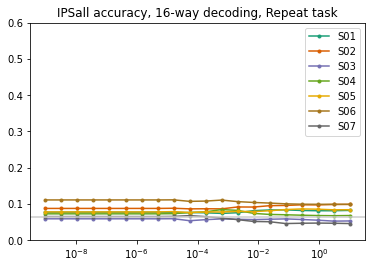

In [203]:
c_values = np.logspace(-9, 1, 20)

for rr in [7]:
# for rr in range(n_rois):
# for rr in [0,1,2,3]:
    
    for ti in range(n_tasks):


        plt.figure()

        for si in range(n_subjects):

            # vals = np.mean(np.mean(dec['acc_each_cval'][si, rr, :, :, :], axis=0), axis=0)
            vals = np.mean(dec['acc_each_cval'][si, rr, ti, :, :], axis=0)

            plt.plot(c_values, vals, '.-', color=subcolors[si,:], )

        plt.gca().set_xscale('log')
        plt.legend(['S%02d'%ss for ss in subjects])

        plt.ylim([0, 0.6])
        plt.axhline(1/16, color=[0.8, 0.8, 0.8])
        plt.title('%s accuracy, 16-way decoding, %s task'%(roi_names[rr], task_names[ti]))

#### Accuracy within each task

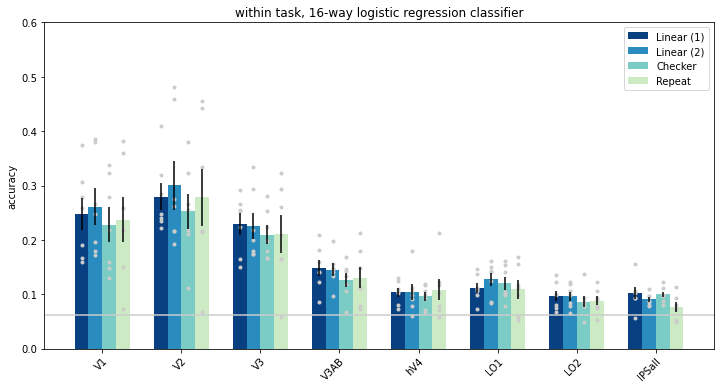

In [19]:
vals = within

meanvals = np.mean(vals, axis=0)
semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

plot_utils.plot_multi_bars(mean_data = meanvals, \
                           err_data = semvals, \
                           point_data = vals, \
                           add_ss_lines=False,
                           colors = task_colors, \
                           space = 0.15, \
                           title = 'within task, 16-way logistic regression classifier', \
                           ylim = [0, 0.6], \
                           horizontal_line_pos = 1/16,
                           xticklabels = roi_names, \
                           ylabel = 'accuracy', \
                           legend_overlaid=True, \
                           legend_separate=False, \
                           legend_labels = np.array(task_names));

#### Make confusion matrix

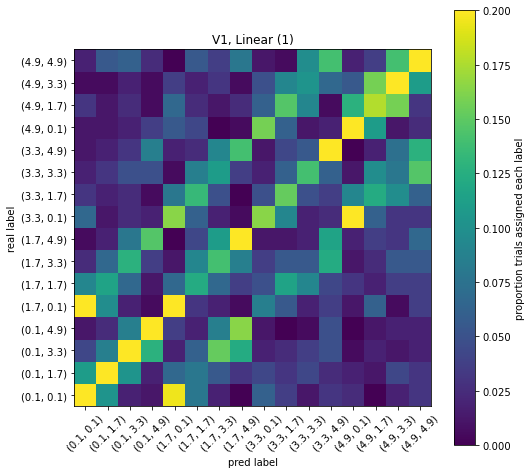

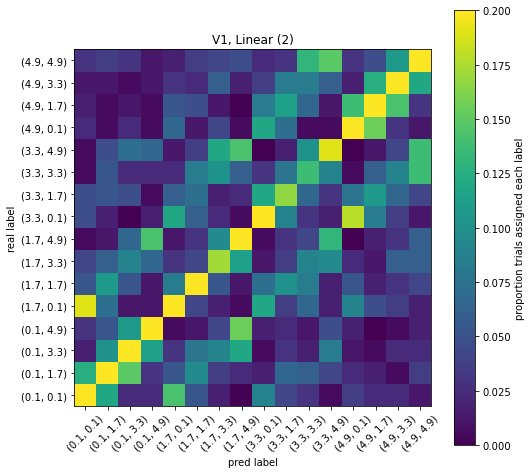

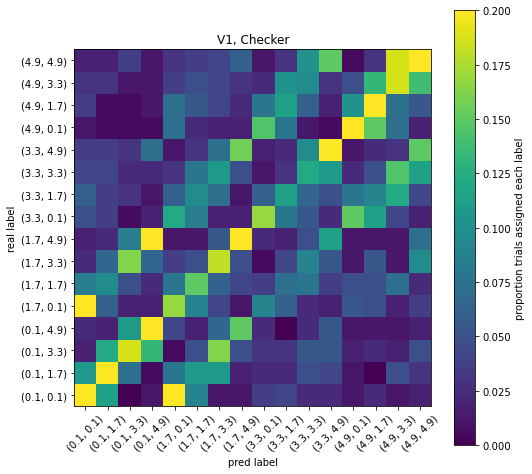

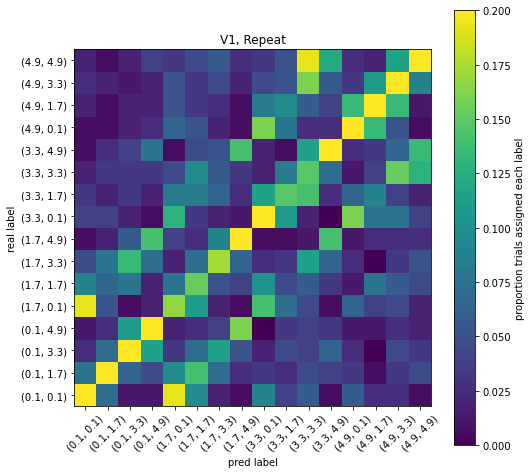

In [20]:
# ri = 7;
ri = 0;

for ti in range(n_tasks):

    # sum over subjects
    n = np.sum(dec['num_preds_bytask'][:,ri,:,:,ti,ti], axis=0)
    # sum over all trials with same "real label"
    s = np.tile(np.sum(n, axis=1, keepdims=True), [1,n.shape[1]])
    prop_conf =  n/s

    plt.figure(figsize=(8,8))
    plt.pcolormesh(prop_conf, vmin=0, vmax=0.20)
    plt.colorbar(label='proportion trials assigned each label')
    plt.ylabel('real label')
    plt.xlabel('pred label')
    plt.xticks(np.arange(0.5, 16.5, 1.0), grid_pt_strs, rotation=45);
    plt.yticks(np.arange(0.5, 16.5, 1.0), grid_pt_strs);
    plt.axis('square')
    plt.title('%s, %s'%(roi_names[ri], task_names[ti]))

#### Make idealized confusion matrices for each task

In [22]:
n_grid_pts = 16;
center =2.5
ideal_conf_matrices = np.zeros((n_grid_pts, n_grid_pts, n_tasks))
for gg1 in range(n_grid_pts):
    for gg2 in range(n_grid_pts):
        
        pt1 = grid_pts[gg1,:]
        pt2 = grid_pts[gg2,:]
        
        xcat1 = pt1[0]>center
        xcat2 = pt2[0]>center
        
        ycat1 = pt1[1]>center
        ycat2 = pt2[1]>center
        
        if xcat1==xcat2:
            ideal_conf_matrices[gg1,gg2,0] = 1
            
        if ycat1==ycat2:
            ideal_conf_matrices[gg1,gg2,1] = 1
            
        checker1 = np.sum(pt1>center)==1
        checker2 = np.sum(pt2>center)==1
        
        if checker1==checker2:
            ideal_conf_matrices[gg1,gg2,2] = 1
            
        if np.all(pt1==pt2):
            ideal_conf_matrices[gg1,gg2,3] = 1
            

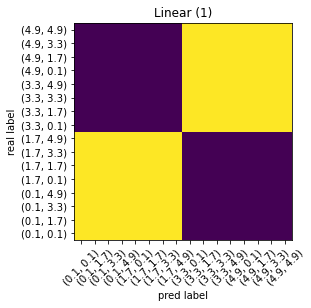

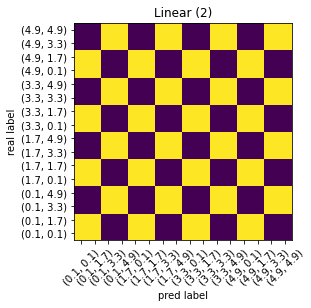

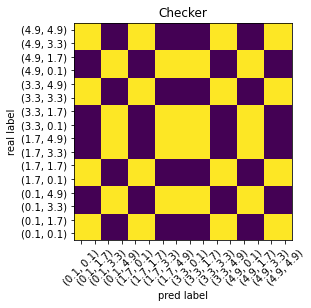

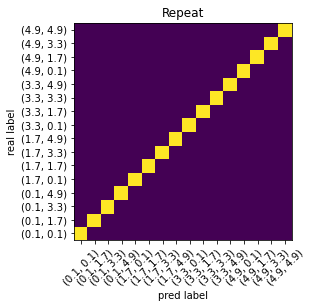

In [23]:
for ti in range(n_tasks):
    
    plt.figure()
    plt.pcolormesh(ideal_conf_matrices[:,:,ti])
    
    plt.ylabel('real label')
    plt.xlabel('pred label')
    plt.xticks(np.arange(0.5, 16.5, 1.0), grid_pt_strs, rotation=45);
    plt.yticks(np.arange(0.5, 16.5, 1.0), grid_pt_strs);
    plt.axis('square')
    plt.title('%s'%task_names[ti])

#### Correlate the confusion matrices with the templates

In [24]:
sim_each = np.zeros((n_subjects, n_rois, n_tasks, n_tasks))

for si in range(n_subjects):

    for ri in range(n_rois):
        for ti in range(n_tasks):

            n = dec['num_preds_bytask'][si,ri,:,:,ti,ti]
            
            # n = np.sum(dec_withintask['num_preds_bytask'][:,ri,:,:,ti], axis=0)
            # sum over all trials with same "real label"
            s = np.tile(np.sum(n, axis=1, keepdims=True), [1,n.shape[1]])
            prop_conf =  n/s

            for ti_compare in range(n_tasks):

                ideal = ideal_conf_matrices[:,:,ti_compare]

                # similarity of ideal with actual
                sim = np.corrcoef(prop_conf.ravel(), ideal.ravel())[0,1]

                sim_each[si, ri, ti, ti_compare] = sim

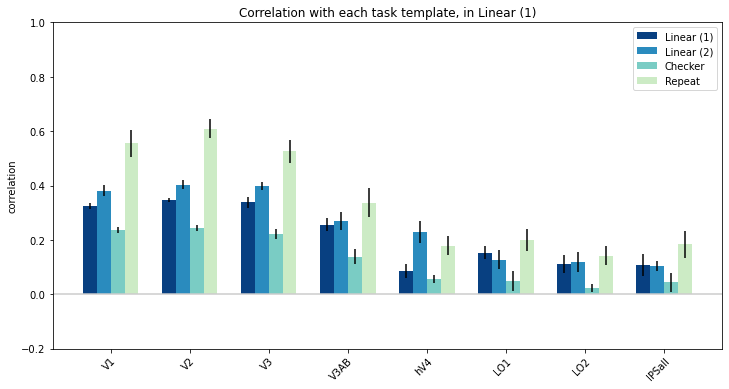

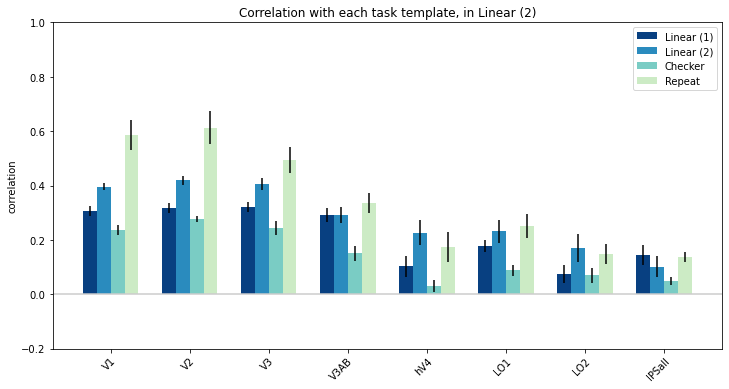

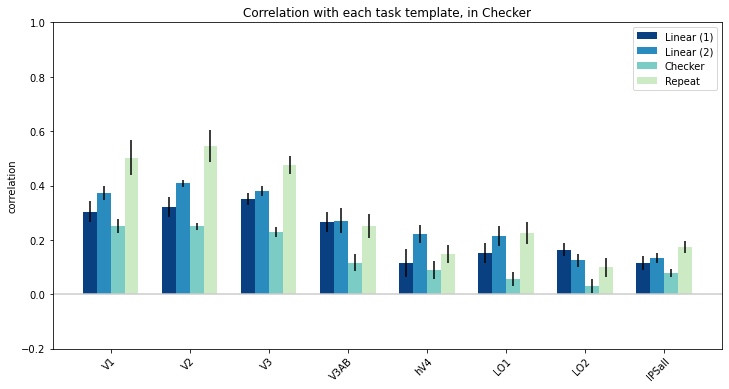

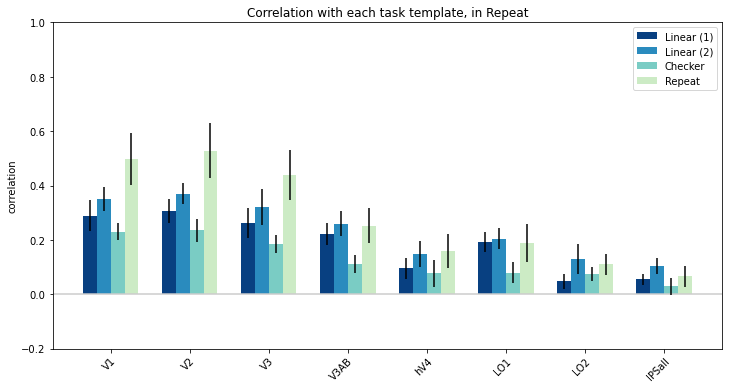

In [25]:
for ti in range(n_tasks):

    vals = sim_each[:,:,ti,:]
    
    
    meanvals = np.mean(vals, axis=0)
    semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

    plot_utils.plot_multi_bars(mean_data = meanvals, \
                               err_data = semvals, \
                               # point_data = vals, \
                               # add_ss_lines=False,
                               colors = task_colors, \
                               space = 0.15, \
                               title = 'Correlation with each task template, in %s'%task_names[ti], \
                               ylim = [-0.2, 1.0], 
                               # horizontal_line_pos = 1/16,
                               xticklabels = roi_names, \
                               ylabel = 'correlation', \
                               legend_overlaid=True, \
                               legend_separate=False, \
                               legend_labels = np.array(task_names));